In [1]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
seed = 42

In [3]:
df = pd.read_csv('../data/from_pyupbit/KRW-ETH.csv')

In [4]:
df

,timestamp,open,high,low,close,volume,value
0,2021-09-27 16:41:00,3737000.0,3741000.0,3737000.0,3740000.0,26.211112,9.802993e+07
1,2021-09-27 16:42:00,3741000.0,3741000.0,3739000.0,3739000.0,13.748591,5.140882e+07
2,2021-09-27 16:43:00,3738000.0,3741000.0,3738000.0,3740000.0,27.905444,1.043716e+08
3,2021-09-27 16:44:00,3740000.0,3744000.0,3740000.0,3744000.0,18.936442,7.083924e+07
4,2021-09-27 16:45:00,3744000.0,3745000.0,3742000.0,3743000.0,12.745847,4.771550e+07
...,...,...,...,...,...,...,...
1576795,2024-10-12 17:32:00,3302000.0,3302000.0,3302000.0,3302000.0,2.521127,8.324761e+06
1576796,2024-10-12 17:33:00,3302000.0,3302000.0,3300000.0,3302000.0,2.657685,8.775670e+06
1576797,2024-10-12 17:34:00,3302000.0,3302000.0,3300000.0,3302000.0,1.076884,3.555856e+06
1576798,2024-10-12 17:35:00,3302000.0,3302000.0,3302000.0,3302000.0,1.430845,4.724651e+06


In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))
joblib.dump(scaler, 'models/KRW-ETH_scaler.pkl')

['models/KRW-ETH_scaler.pkl']

In [7]:
timestep = 1

In [8]:
X = []
y = []
for i in range(len(scaled_data) - timestep - 1):
    X.append(scaled_data[i:(i + timestep), 0])
    y.append(scaled_data[i + timestep, 0])

In [9]:
X, y = np.array(X), np.array(y)

In [10]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [11]:
train_dates = df.index[:train_size]
test_dates = df.index[train_size:len(X)]

In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [13]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timestep, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [16]:
model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/20
39420/39420 [==============================] - 399s 10ms/step - loss: 9.1307e-05 - val_loss: 3.5752e-06
Epoch 2/20
39420/39420 [==============================] - 417s 11ms/step - loss: 1.5579e-06 - val_loss: 1.5784e-06
Epoch 3/20
39420/39420 [==============================] - 416s 11ms/step - loss: 1.3692e-06 - val_loss: 4.2993e-06
Epoch 4/20
39420/39420 [==============================] - 412s 10ms/step - loss: 1.1959e-06 - val_loss: 3.1172e-06
Epoch 5/20
39420/39420 [==============================] - 412s 10ms/step - loss: 1.1190e-06 - val_loss: 2.7677e-06
Epoch 6/20
39420/39420 [==============================] - 414s 10ms/step - loss: 1.0735e-06 - val_loss: 2.5051e-06
Epoch 7/20
39420/39420 [==============================] - 416s 11ms/step - loss: 1.0034e-06 - val_loss: 7.1494e-07
Epoch 8/20
39420/39420 [==============================] - 401s 10ms/step - loss: 9.7753e-07 - val_loss: 7.7426e-07
Epoch 9/20
39420/39420 [==============================] - 399s 10ms/step - loss:

In [17]:
model.save('models/lstm_KRW-ETH.h5')

In [18]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9855/9855 [==============================] - 37s 4ms/step


In [19]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

In [20]:
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print(f'Train RMSE: {train_score:.2f}')
print(f'Test RMSE: {test_score:.2f}')

Train RMSE: 3158.02
Test RMSE: 4790.41


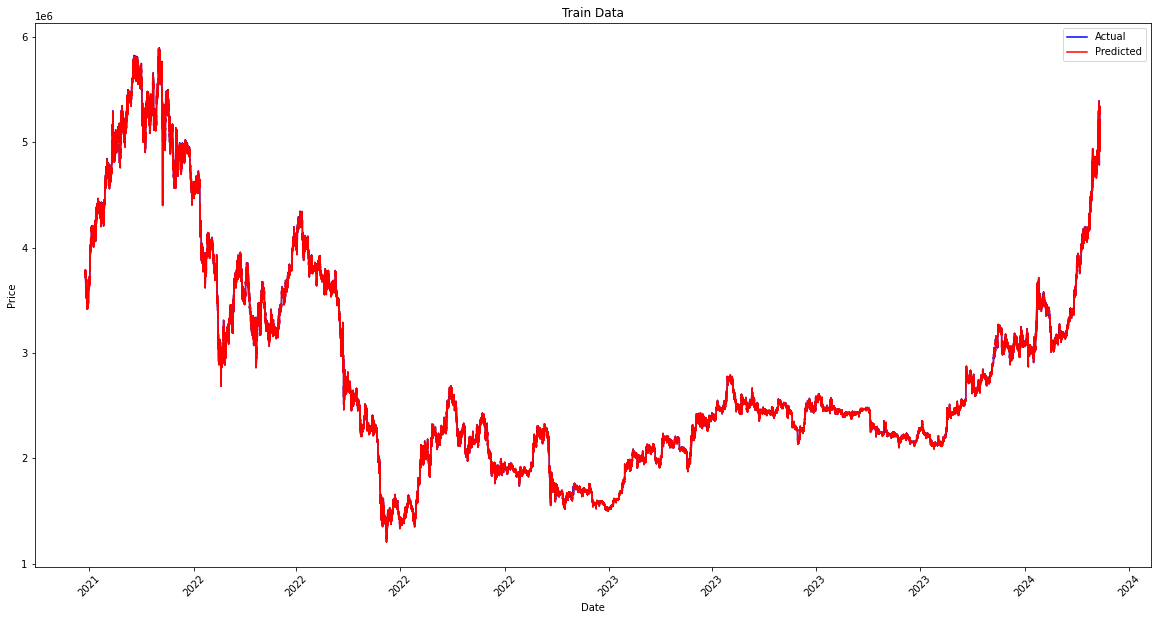

In [21]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 1, 1)
plt.plot(train_dates, y_train[0], label='Actual', color = 'Blue')
plt.plot(train_dates, train_predict, label='Predicted', color = 'Red')
plt.title('Train Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

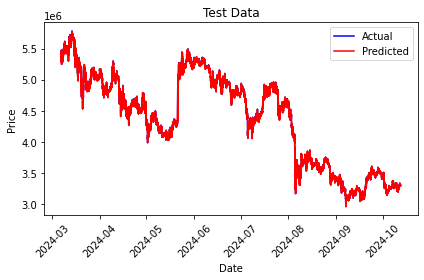

In [22]:
plt.subplot(1, 1, 1)
plt.plot(test_dates, y_test[0], label='Actual', color = 'Blue')
plt.plot(test_dates, test_predict, label='Predicted', color = 'Red')
plt.title('Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [23]:
last_1_day = scaled_data[-timestep:]
X_predict = last_1_day.reshape(1, timestep, 1)
print(scaler.inverse_transform(last_1_day))

[[3300000.]]


In [24]:
preds = []
for i in range(30):  # 30분 예측
    pred = model.predict(X_predict)
    preds.append(pred[0][0])
    pred = pred.reshape(1, 1, 1)
    X_predict = np.append(X_predict[:, 1:, :], pred, axis=1).reshape(1, timestep, 1)

1/1 [==============================] - 0s 13ms/step


In [25]:
preds = scaler.inverse_transform([preds])

In [26]:
preds

array([[3299050.66436529, 3298102.26663947, 3297155.26649356,
        3296209.24465358, 3295264.34087753, 3294320.55516541,
        3293377.88751721, 3292436.19817495, 3291495.62689662,
        3290556.17368221, 3289617.83853173, 3288680.62144518,
        3287744.24290657, 3286808.98243189, 3285874.84002113,
        3284941.8156743 , 3284009.76963341, 3283078.98141444,
        3282149.1715014 , 3281220.33989429, 3280292.62635112,
        3279365.89111388, 3278440.13418257, 3277515.49531519,
        3276591.83475375, 3275669.29225624, 3274747.58830667,
        3273827.00242102, 3272907.39484131, 3271988.76556754]])

In [27]:
# Predict the future
# future_predictions = []
# for _ in range(len(new_df)):
#     pred = model.predict(X_predict)
#     future_predictions.append(pred[0, 0])
#     pred = pred.reshape(1, 1, 1)
#     X_predict = np.append(X_predict[:, 1:, :], pred, axis=1).reshape(1, timestep, 1)
# future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))